In [2]:
import numpy as np
import matplotlib.pyplot as plt, mpld3
import pandas as pd
import plotly.plotly as py
from plotly.graph_objs import *
%matplotlib inline

In [3]:
import block_handler
import plot_chunk

#  Minepath Eval

In [4]:
world = block_handler.load_world('/Users/ryanlambert/Desktop/MinecraftLandGenerator/world')

In [5]:
#print world.get_nbt(-9,-46)['Level']['Sections'][0]['Blocks']

In [6]:
world.get_boundingbox()

BoundingBox(-27,35,None,None,-30,32)

### Path Type: Hallway
Combinations of various heights and spacings

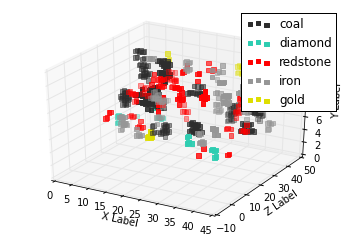

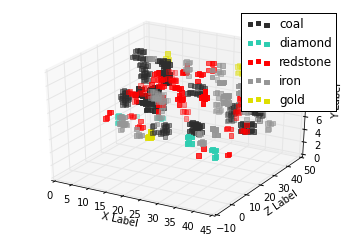

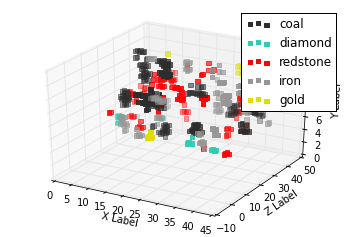

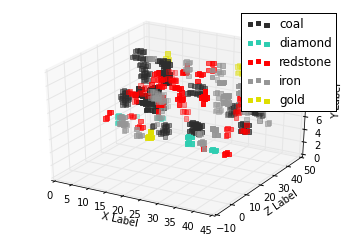

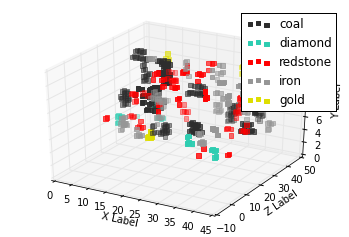

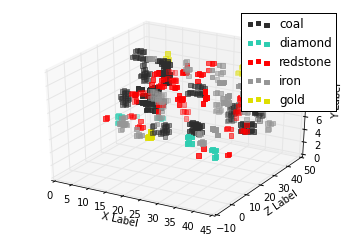

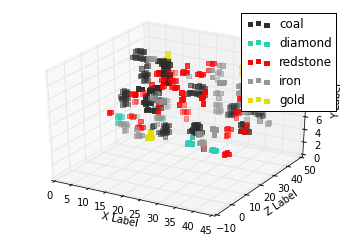

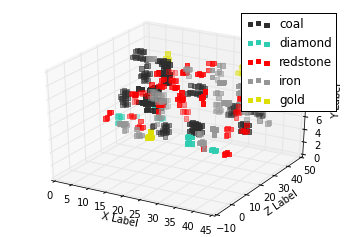

In [1162]:
def mine_hallway_variations(hallway_spacing, hallway_height, max_y_height, y_layer_spacing):
    hallway = []
    for y_pattern in xrange(6, max_y_height, y_layer_spacing): 
        for x in xrange(6, 42, hallway_spacing):
            for z in xrange(2, 48):
                for y in range(y_pattern, y_pattern + hallway_height):
                    hallway.append((x,z,y))

#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     try:
#         xs = [i[0] for i in hallway]
#         zs = [j[1] for j in hallway]
#         ys = [k[2] for k in hallway]
#         ax.scatter(xs, zs, ys, color='green', marker='|')
#         ax.set_zlim3d([0, 17])
#         ax.set_title("Hallway_spacing: %r \n Hallway Height: %s \n Max Y: %s \n Y Spacing: %s"% (hallway_spacing, hallway_height, max_y_height, y_layer_spacing)) 
#         ax.set_xlabel('X')
#         ax.set_ylabel('Z')
#         ax.set_zlabel('Y')
#     except KeyError:
#         print "keyerror"
#         pass

    hallway_ore_filter = {
        'iron':0,
        'diamond':0,
        'redstone':0,
        'coal':0,
        'gold':0,
    }

    blocks, blocks_mined = block_handler.simulation(
        x1=0,
        x2=3,
        z1=0,
        z2=3,
        y1=0,
        y2=1,
        relative_path=hallway,
        ore_count=hallway_ore_filter,
        world=world)


    columns = pd.MultiIndex.from_arrays([hallway_spacing, 
                                        hallway_height, 
#                                        max_y_height, 
                                        y_layer_spacing,], 
                                       names=['Hallway Spacing',
                                             'Hallway Height',
#                                              'Max Y',
                                             'Y Spacing',])

    temp = pd.DataFrame(
        blocks.values(),
        [[i[0] for i in blocks.keys()],
        [i[1] for i in blocks.keys()],
        [i[2] for i in blocks.keys()],
        ],
        columns=columns)

#     temp = pd.DataFrame(
#         [blocks.values(),
#         [i[0] for i in blocks.keys()],
#         [i[1] for i in blocks.keys()],
#         [i[2] for i in blocks.keys()],],
#         index=[
#             'type',
#             'x',
#             'z',
#             'y',
#         ])
    
    temp_blocks_mined = pd.DataFrame(
        [len(blocks_mined)],
        columns=columns)
    
    return temp, temp_blocks_mined

df = pd.DataFrame()
total_blocks_mined = pd.DataFrame()
for y_layer_spacing in [3, 4]:
    for hallway_spacing in [2, 3]:
        for hallway_height in [2, 3]:
            temp, blocks_mined = mine_hallway_variations(
                hallway_spacing=hallway_spacing, 
                hallway_height=hallway_height, 
                max_y_height=16, 
                y_layer_spacing=y_layer_spacing
                )
        
        df = pd.concat([df, temp], join='outer', axis=1)
        total_blocks_mined = pd.concat([total_blocks_mined, blocks_mined], axis=1)


total_blocks_mined = total_blocks_mined.T.rename(columns={0:'mined'}).T
df = df.sortlevel(2).sortlevel(1).sortlevel(0)



In [1170]:
total_blocks_mined

Hallway Spacing,2,3,2,3
Hallway Height,3,3,3,3
Y Spacing,3,3,4,4
mined,9936,6624,7452,4968


##### Descriptive Stats on Sampling Confidence

In [1171]:
temp = None
temp = pd.DataFrame()
x_sample_size = 8
z_sample_size = 8
for x in xrange(0, 47, x_sample_size):
    for z in xrange(0, 47, z_sample_size):
        temp = pd.concat(
            [
            temp, 
            df.loc[
                    (
                        slice(x , x + x_sample_size - 1), 
                        slice(z , z + z_sample_size - 1)
                    ),
               :
              ][2][3][3].value_counts(), 
            ], 
            axis=1,
            join='outer'
        )

temp.T.describe()

,coal,diamond,gold,iron,redstone
count,21.000000,8.000000,4.000000,24.000000,21.000000
mean,13.952381,4.625000,4.750000,6.458333,6.714286
std,13.514719,2.825269,3.593976,3.671028,3.100691
min,2.000000,1.000000,2.000000,2.000000,2.000000
25%,4.000000,2.750000,2.750000,3.000000,5.000000
50%,12.000000,4.000000,3.500000,6.000000,6.000000
75%,20.000000,6.500000,5.500000,9.000000,9.000000
max,52.000000,9.000000,10.000000,16.000000,13.000000


##### Hallway Spacing 2

##### Hallway Spacing 3

In [860]:
temp

Hallway Height  3   
Y Spacing       3  4
0               2  2

In [ ]:
#pandasblocks.sort_index()
#pandasblocks.sortlevel().unstack()
#indexby_coords = pandasblocks.sortlevel().unstack()
indexby_coords = pandasblocks.sortlevel()
#df = indexby_coords.fillna("")

In [ ]:
df = indexby_coords.T

In [ ]:
df.head()

### Path Type: Branch Leaf: leaf_spacing = 4, branch_spacing = 12

In [ ]:
branch_leaf = []
leaf_spacing = 4
branch_spacing = 12
for y_pattern in xrange(0, 4, 3): 
    for x in xrange(6, 42, branch_spacing):
        for z in xrange(2, 48):
            for y in range(6 + y_pattern,8 + y_pattern):
                branch_leaf.append((x,z,y))
    ### leaves
        for z in xrange(3, 48, leaf_spacing): 
            for x_2 in xrange(x, x + 6): 
                for y in range(7 + y_pattern,8 + y_pattern):
                    branch_leaf.append((x_2,z,y))
            for x_3 in xrange(x - 5, x): 
                for y in range(7 + y_pattern,8 + y_pattern):
                    branch_leaf.append((x_3,z,y))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

try:
    xs = [i[0] for i in branch_leaf]
    zs = [j[1] for j in branch_leaf]
    ys = [k[2] for k in branch_leaf]
    ax.scatter(xs, zs, ys, color='green', marker='|')
    ax.set_zlim3d([0, 17])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
except KeyError:
    pass

branch_leaf_ore_filter = {
    'iron':0,
    'diamond':0,
    'redstone':0,
#    'coal':0,
    'gold':0,
}
blocks, branch_leaf = block_handler.simulation(
    x1=-15,
    x2=15,
    z1=-15,
    z2=15,
    y1=0,
    y2=1,
    relative_path=branch_leaf,
    ore_count=branch_leaf_ore_filter,
    world=world)
ore_counts = pd.DataFrame([branch_leaf_ore_filter], index=['branch_leaf lf_space=4 br_space=12'])
branch_leaf_efficiency = ore_counts / len(branch_leaf) * 100
branch_leaf_efficiency
print len(blocks)
index_x = [i[0] for i in blocks.keys()]
index_z = [i[1] for i in blocks.keys()]
index_y = [i[2] for i in blocks.keys()]
pandasblocks['branch_leaf lf_space=4 br_space=12'] = pd.DataFrame(blocks.values(), [index_x, index_z, index_y])

### Comparison of Paths' Performance

In [ ]:
all_efficiencies = pd.concat([branch_leaf_lf3_br12_efficiency,
                    branch_leaf_efficiency, 
                    branch_leaf_lf5_br12_efficiency,
                    branch_leaf_lf6_br12_efficiency,
                    branch_leaf_lf7_br12_efficiency,
                    one_by_two_efficiency, 
                    one_by_two_4space_efficiency,
                             ])
all_efficiencies

In [ ]:
branch_leaf_efficiencies = pd.concat([branch_leaf_lf3_br12_efficiency,
                    branch_leaf_efficiency, 
                    branch_leaf_lf5_br12_efficiency,
                    branch_leaf_lf6_br12_efficiency,
                    branch_leaf_lf7_br12_efficiency,
                    ])
branch_leaf_efficiencies

In [ ]:
branch_leaf_efficiencies.sort().T.plot(kind='bar', title="Branch_Leaf_Mining_Efficiencies", figsize=(10,7))

In [ ]:
one_by_two_efficiencies = pd.concat([one_by_two_efficiency, 
                    one_by_two_4space_efficiency,
                    one_by_two_6space_efficiency,
                    one_by_two_8space_efficiency,
                    one_by_two_10space_efficiency,])
one_by_two_efficiencies

In [ ]:
one_by_two_efficiencies.sort().T.plot(kind='bar', title="1 x 2 spacing optimization", figsize=(10,7))

### Compare the Two Top Performers for Diamonds

In [ ]:
top_diamond_performers = pd.concat([branch_leaf_efficiency, one_by_two_efficiency])
top_diamond_performers.diamond.plot(kind='bar', title='Diamonds', grid=True)
top_diamond_performers.T.plot(kind='bar')

##### Send to plot.ly

In [ ]:
top_diamond_performers.T.index.tolist()

In [ ]:
branch_leaf_data = top_diamond_performers.T['branch_leaf lf_space=4 br_space=12'].tolist()
one_by_two = top_diamond_performers.T['one_by_two_3space'].tolist()

In [ ]:
trace1 = Bar(
    x=top_diamond_performers.T.index.tolist(),
    y=branch_leaf_data,
    name='branch_leaf'
)

trace2 = Bar(
    x=top_diamond_performers.T.index.tolist(),
    y=one_by_two,
    name='one_by_two'
)

data = Data([trace1, trace2])
layout = Layout(
    barmode='group'
)
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='test1234')